In [1]:
from vivarium import Artifact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db_queries import get_ids, get_outputs
import scipy.stats
from get_draws.api import get_draws

In [2]:
output_dirs = ['/share/costeffectiveness/results/vivarium_conic_lsff/india/2020_06_26_20_35_00/count_data/',
              '/share/costeffectiveness/results/vivarium_conic_lsff/nigeria/2020_06_26_20_28_27/count_data/']

locations = ['India','Nigeria']

In [3]:
anemia_pt = pd.read_hdf(output_dirs[0] + 'anemia_state_person_time.hdf')
anemia_pt.head()

,year,age_group,sex,measure,input_draw,scenario,value
0,2020,1_to_4,female,anemia_mild,21,baseline,44605.015743
1,2020,1_to_4,female,anemia_mild,21,folic_acid_fortification_scale_up,44605.015743
2,2020,1_to_4,female,anemia_mild,21,iron_folic_acid_fortification_scale_up,44605.015743
3,2020,1_to_4,female,anemia_mild,21,vitamin_a_fortification_scale_up,44605.015743
4,2020,1_to_4,female,anemia_mild,29,baseline,43965.626283


In [4]:
# get simulation anemia prevalence

anemia_prev = pd.DataFrame()
for i in range(len(output_dirs)):
    anemia_pt = pd.read_hdf(output_dirs[i] + 'anemia_state_person_time.hdf')
    anemia_pt = anemia_pt.groupby(['input_draw','age_group','scenario','year','measure']).sum()
    pt = pd.read_hdf(output_dirs[i] + 'state_person_time.hdf')
    pt = pt.loc[pt.cause.str.contains('diarrheal')]
    pt = pt.groupby(['input_draw','age_group','scenario','year']).sum()
    prev = anemia_pt / pt
    prev = prev.reset_index()
    prev['location'] = locations[i]
    anemia_prev = anemia_prev.append(prev)
anemia_prev = anemia_prev.rename(columns={'measure':'cause'})
anemia_prev.head()

,input_draw,age_group,scenario,year,cause,value,location
0,21,1_to_4,baseline,2020,anemia_mild,0.291698,India
1,21,1_to_4,baseline,2020,anemia_moderate,0.289239,India
2,21,1_to_4,baseline,2020,anemia_none,0.406519,India
3,21,1_to_4,baseline,2020,anemia_severe,0.012544,India
4,21,1_to_4,baseline,2021,anemia_mild,0.291546,India


In [17]:
# get simulation anemia prevalence

total_anemia_prev = pd.DataFrame()
for i in range(len(output_dirs)):
    anemia_pt = pd.read_hdf(output_dirs[i] + 'anemia_state_person_time.hdf')
    anemia_pt = anemia_pt.loc[anemia_pt.measure != 'anemia_none']
    anemia_pt = anemia_pt.groupby(['input_draw','age_group','scenario','year']).sum()
    pt = pd.read_hdf(output_dirs[i] + 'state_person_time.hdf')
    pt = pt.loc[pt.cause.str.contains('diarrheal')]
    pt = pt.groupby(['input_draw','age_group','scenario','year']).sum()
    prev = anemia_pt / pt
    prev = prev.reset_index()
    prev['location'] = locations[i]
    total_anemia_prev = total_anemia_prev.append(prev)
total_anemia_prev['cause'] = 'total_anemia'
total_anemia_prev.head()

,input_draw,age_group,scenario,year,value,location,cause
0,21,1_to_4,baseline,2020,0.593481,India,total_anemia
1,21,1_to_4,baseline,2021,0.592931,India,total_anemia
2,21,1_to_4,baseline,2022,0.593171,India,total_anemia
3,21,1_to_4,baseline,2023,0.593735,India,total_anemia
4,21,1_to_4,folic_acid_fortification_scale_up,2020,0.593481,India,total_anemia


In [5]:
test = anemia_prev.loc[anemia_prev.age_group == '1_to_4']
test = test.loc[test.year == '2022']
test = test.loc[test.scenario.isin(['baseline','iron_folic_acid_fortification_scale_up'])]
test = test.set_index(['input_draw','age_group','year','cause','location','scenario']).sort_index()
test.head()

# results look like expected, just VERY SMALL difference in anemia prevalence

value
input_draw age_group year cause           location scenario                                        
21         1_to_4    2022 anemia_mild     India    baseline                                0.291207
                                                   iron_folic_acid_fortification_scale_up  0.290107
                                          Nigeria  baseline                                0.250319
                                                   iron_folic_acid_fortification_scale_up  0.249122
                          anemia_moderate India    baseline                                0.289515

In [6]:
state_pt = pd.read_hdf(output_dirs[i] + 'state_person_time.hdf')
state_pt.head()

,year,age_group,cause,folic_acid_fortification_group,vitamin_a_fortification_group,measure,input_draw,scenario,value
0,2020,1_to_4,diarrheal_diseases,covered,covered,person_time,21,baseline,0.0
1,2020,1_to_4,diarrheal_diseases,covered,covered,person_time,21,folic_acid_fortification_scale_up,0.0
2,2020,1_to_4,diarrheal_diseases,covered,covered,person_time,21,iron_folic_acid_fortification_scale_up,0.0
3,2020,1_to_4,diarrheal_diseases,covered,covered,person_time,21,vitamin_a_fortification_scale_up,0.0
4,2020,1_to_4,diarrheal_diseases,covered,covered,person_time,29,baseline,0.0


In [7]:
# state person time for non-anemia causes

prevs = pd.DataFrame()
for i in range(len(output_dirs)):
    state_pt = pd.read_hdf(output_dirs[i] + 'state_person_time.hdf')
    state_pt = state_pt.groupby(['input_draw','age_group','scenario','year','cause']).sum()
    pt = pd.read_hdf(output_dirs[i] + 'state_person_time.hdf')
    pt = pt.loc[pt.cause.str.contains('diarrheal')]
    pt = pt.groupby(['input_draw','age_group','scenario','year']).sum()
    prev = state_pt / pt
    prev = prev.reset_index()
    prev['location'] = locations[i]
    prevs = prevs.append(prev)
prevs.head()

,input_draw,age_group,scenario,year,cause,value,location
0,21,1_to_4,baseline,2020,diarrheal_diseases,0.011462,India
1,21,1_to_4,baseline,2020,lower_respiratory_infections,0.002263,India
2,21,1_to_4,baseline,2020,measles,0.000869,India
3,21,1_to_4,baseline,2020,neural_tube_defects,0.000502,India
4,21,1_to_4,baseline,2020,susceptible_to_diarrheal_diseases,0.988538,India


In [8]:
np.unique(prevs['scenario'])

array(['baseline', 'folic_acid_fortification_scale_up',
       'iron_folic_acid_fortification_scale_up',
       'vitamin_a_fortification_scale_up'], dtype=object)

In [24]:
def make_multiple_plots_by_year_and_cause(dataset, locations, causes, scenarios):
    for location in locations:
            for cause in causes:
                for scenario in scenarios:
                    data = dataset.loc[dataset.location == location]
                    data = data.loc[data.cause == cause]
                    data['value'] = data['value'] * 100
                    data = data.groupby(['location','scenario','year']).describe().reset_index()

                    baseline = data.loc[data.scenario == 'baseline']
                    ifa = data.loc[data.scenario == scenario]

                    fig, ax = plt.subplots(figsize=(7.5, 5))

                    plt.scatter(baseline['year'], baseline['value','mean'])
                    plt.plot(baseline['year'], baseline['value','mean'])

                    plt.scatter(ifa['year'], ifa['value','mean'])
                    plt.plot(ifa['year'], ifa['value','mean'])

                    plt.fill_between(baseline['year'],baseline['value','max'],baseline['value','min'], alpha=0.3,color='tab:blue')
                    plt.fill_between(ifa['year'],ifa['value','max'],ifa['value','min'], alpha=0.3,color='tab:orange')

                    cause_title = cause.replace('_',' ').capitalize()
                    scenario_title = scenario.replace('_',' ').capitalize()

                    plt.title(f'{location}\n Prevalence of {cause_title}')
                    plt.legend(['Baseline',f'{scenario}'])
                    plt.ylabel(f'{cause_title} Prevalence')
                    plt.savefig(f'prevalence_{location}_{scenario}_{cause}.png')

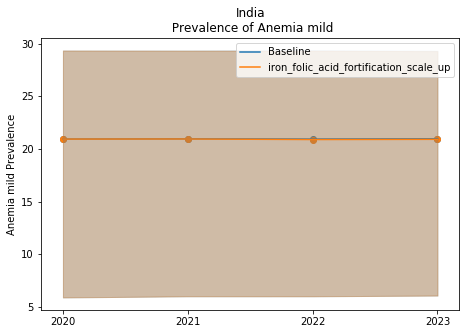

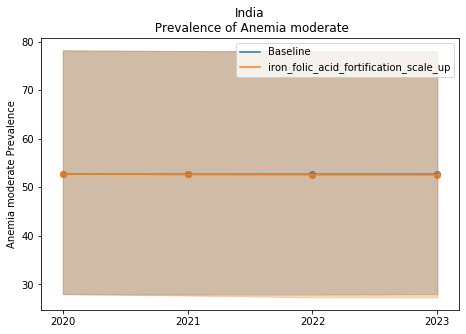

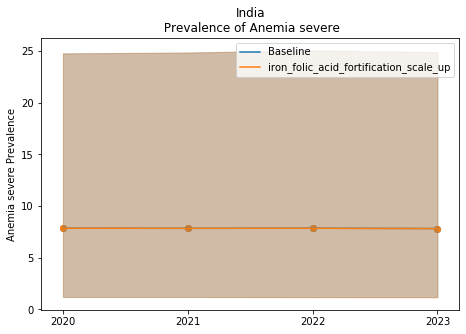

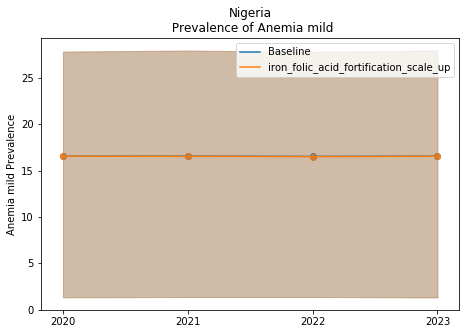

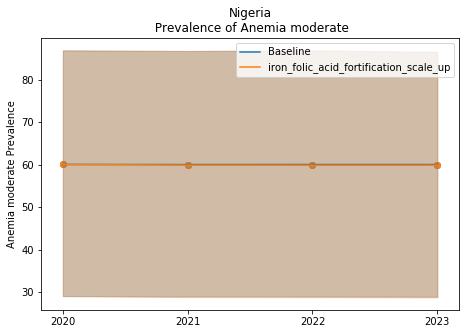

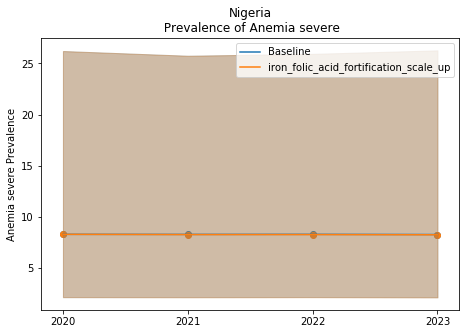

In [25]:
dataset = anemia_prev
locs = locations
causes = ['anemia_mild','anemia_moderate','anemia_severe']
scenarios = ['iron_folic_acid_fortification_scale_up']

make_multiple_plots_by_year_and_cause(dataset, locs, causes, scenarios)

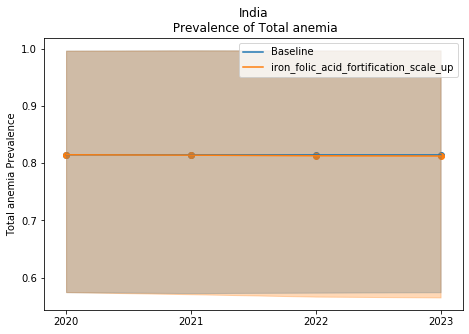

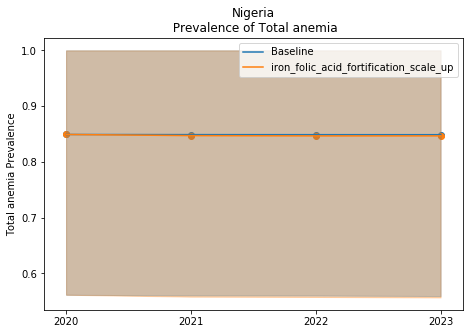

In [19]:
dataset = total_anemia_prev
locs = locations
causes = ['total_anemia']
scenarios = ['iron_folic_acid_fortification_scale_up']

make_multiple_plots_by_year_and_cause(dataset, locs, causes, scenarios)

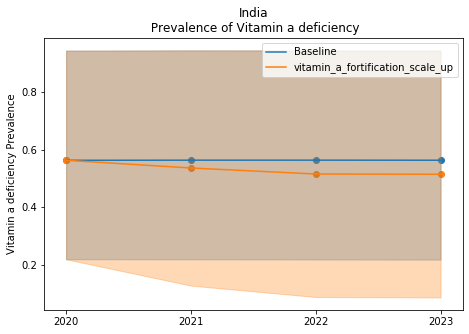

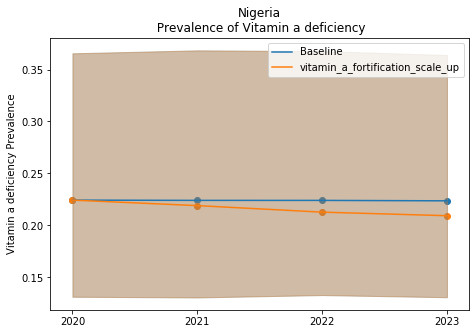

In [11]:
dataset = prevs
locs = locations
causes = ['vitamin_a_deficiency']
scenarios = ['vitamin_a_fortification_scale_up']

make_multiple_plots_by_year_and_cause(dataset, locs, causes, scenarios)